In [4]:
from dotenv import load_dotenv
from typing import Dict, List, Any, Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langsmith import traceable
from langgraph.types import interrupt, Command
from langgraph.graph import MessagesState
from fnol_agent import call_agent as fnol_call_agent, resume_agent as fnol_resume_agent
from claim_agent import call_agent as claim_call_agent, resume_agent as claim_resume_agent

from uuid import uuid4
load_dotenv()

True

/var/folders/jf/b25__sb90v5d2gj3lycn7wmw0000gn/T/ipykernel_65179/4150766873.py:63: UserWarning: The 'config' parameter should be typed as 'RunnableConfig' or 'RunnableConfig | None', not 'typing.Dict'. 
  builder.add_node("fnol_agent", fnol_agent_node)
/var/folders/jf/b25__sb90v5d2gj3lycn7wmw0000gn/T/ipykernel_65179/4150766873.py:64: UserWarning: The 'config' parameter should be typed as 'RunnableConfig' or 'RunnableConfig | None', not 'typing.Dict'. 
  builder.add_node("claim_agent", claim_agent_node)


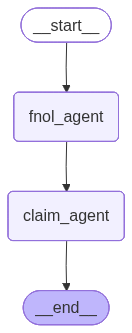

In [2]:
# Agent

class OrchestratorState(MessagesState):
    pass


def fnol_agent_node(state: OrchestratorState, config: Dict = None) -> OrchestratorState:
    if not state.get("messages"):
        return state

    last_message = state["messages"][-1]
    msg_content = getattr(last_message, "content", str(last_message))

    agent_config = config or {}

    # Call FNOL agent
    result = fnol_call_agent(msg_content, agent_config)

    # result should be the agent state dict, including "messages"
    if isinstance(result, dict) and "messages" in result:
        combined_messages = [
            *state.get("messages", []),
            *result["messages"],
        ]
        return {**state, "messages": combined_messages}

    return state


def claim_agent_node(state: OrchestratorState, config: Dict = None) -> OrchestratorState:
    if not state.get("messages"):
        return state

    # Take the last message (which should include the FNOL info)
    last_message = state["messages"][-1]
    msg_content = getattr(last_message, "content", str(last_message))

    agent_config = config or {}

    # Call Claim agent with whatever FNOL result text we got
    result = claim_call_agent(msg_content, agent_config)

    if isinstance(result, dict) and "messages" in result:
        combined_messages = [
            *state.get("messages", []),
            *result["messages"],
        ]
        return {**state, "messages": combined_messages}

    return state



# Tool and LLM definition
tools = []
llm = ChatOpenAI(model="gpt-5-nano", temperature=0.7)
llm_with_tools = llm.bind_tools(tools)
# Memory
memory = MemorySaver() # This is in-memory saver for testing purposes

# Graph Builder
builder = StateGraph(OrchestratorState)
builder.add_node("fnol_agent", fnol_agent_node)
builder.add_node("claim_agent", claim_agent_node)

builder.add_edge(START, "fnol_agent")
builder.add_edge("fnol_agent", "claim_agent")
builder.add_edge("claim_agent", END)


graph = builder.compile(checkpointer=memory)

# Initial call to the agent
@traceable(run_type="llm", name="call_agent")
def call_agent(msg: str, config: Dict) -> Dict:
    message = msg if isinstance(msg, (HumanMessage, AIMessage, ToolMessage, SystemMessage)) else HumanMessage(content=msg)
    return graph.invoke({"messages": [message]}, config=config)

# Resume the agent after human-in-the-loop input
@traceable(run_type="llm", name="resume_agent")
def resume_agent(decision: str, config: Dict) -> Dict:
    """Resume an interrupted agent execution with a decision."""
    print(f"[AGENT] Resuming with human decision: {decision}")
    result = graph.invoke(Command(resume=decision), config=config)
    print(f"[AGENT] Resume completed")
    return result


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [3]:
email_text = """Subject: Need to Report a Water Leak – Policy HO3-77889900

Hi there,

I wanted to let you know that we had a water leak at my house yesterday and I need to open a claim.

On 2/19 around 2:35 PM, the supply line under our upstairs bathroom sink burst while no one was home. When we got back, water had leaked through the floor and into the living room ceiling, so there’s some noticeable damage to the ceiling and the flooring below.

We shut off the main water valve, had an emergency plumber come out to replace the broken line, and used buckets, towels, and fans overnight to keep things under control. No one was hurt, but the living room ceiling is sagging a bit.

I’m usually available most mornings if someone needs to come take a look.  
Weather was light rain yesterday, but this doesn’t seem related.

My details are:
- Name: John Doe  
- Email: john.doe@example.com  
- Policy Number: HO3-77889900  
- Address: 1245 Westbrook Ave, Austin, TX 78704  

Let me know what the next steps are or if you need photos (I haven’t taken any yet).

Thanks,  
John"""

THREAD_ID = str(uuid4())

config = {"configurable": {"thread_id": THREAD_ID}}

state = call_agent(email_text, config=config)



/Users/maxicorona/Projects/Britecore/1. Drafts/agentic-poc/.venv/lib/python3.13/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


In [4]:
state

{'messages': [HumanMessage(content='Subject: Need to Report a Water Leak – Policy HO3-77889900\n\nHi there,\n\nI wanted to let you know that we had a water leak at my house yesterday and I need to open a claim.\n\nOn 2/19 around 2:35 PM, the supply line under our upstairs bathroom sink burst while no one was home. When we got back, water had leaked through the floor and into the living room ceiling, so there’s some noticeable damage to the ceiling and the flooring below.\n\nWe shut off the main water valve, had an emergency plumber come out to replace the broken line, and used buckets, towels, and fans overnight to keep things under control. No one was hurt, but the living room ceiling is sagging a bit.\n\nI’m usually available most mornings if someone needs to come take a look.  \nWeather was light rain yesterday, but this doesn’t seem related.\n\nMy details are:\n- Name: John Doe  \n- Email: john.doe@example.com  \n- Policy Number: HO3-77889900  \n- Address: 1245 Westbrook Ave, Austi

In [5]:
# Response from the claim agent asking for human input to proceed (human-in-the-loop)
state.get('__interrupt__')[-1].value

{'action': 'send_email',
 'email': 'john.doe@example.com',
 'subject': 'Your Claim has been initialized - HO3-77889900 (CLM-2025-001234)',
 'body': 'Dear John Doe,\n\nA new claim has been created for your policy HO3-77889900.\nClaim ID: CLM-2025-001234\nLoss Date: 2025-02-19 14:35\nLoss Description: Water leak from burst supply line under upstairs bathroom sink; water leaked through floor into living room ceiling; ceiling sagging; no injuries.\n\nWe will notify you with updates as the claim progresses.\n\nBest regards,\nCarson Insurance Group'}

In [6]:
human_subject = state.get('__interrupt__')[-1].value['subject']
human_body = state.get('__interrupt__')[-1].value['body'] + "\n\nPlease call us at 1-555-238-9021 to discuss the claim"

In [7]:
decision = {
    "approved": True,
    "subject": human_subject,
    "body": human_body,
}
state = resume_agent(decision, {"configurable": {"thread_id": THREAD_ID}})

[AGENT] Resuming with human decision: {'approved': True, 'subject': 'Your Claim has been initialized - HO3-77889900 (CLM-2025-001234)', 'body': 'Dear John Doe,\n\nA new claim has been created for your policy HO3-77889900.\nClaim ID: CLM-2025-001234\nLoss Date: 2025-02-19 14:35\nLoss Description: Water leak from burst supply line under upstairs bathroom sink; water leaked through floor into living room ceiling; ceiling sagging; no injuries.\n\nWe will notify you with updates as the claim progresses.\n\nBest regards,\nCarson Insurance Group\n\nPlease call us at 1-555-238-9021 to discuss the claim'}
Email sent: john.doe@example.com with subject Your Claim has been initialized - HO3-77889900 (CLM-2025-001234) and body Dear John Doe,

A new claim has been created for your policy HO3-77889900.
Claim ID: CLM-2025-001234
Loss Date: 2025-02-19 14:35
Loss Description: Water leak from burst supply line under upstairs bathroom sink; water leaked through floor into living room ceiling; ceiling sagg

In [11]:
existing_messages = state.get("messages", [])
existing_messages

[HumanMessage(content='Subject: Need to Report a Water Leak – Policy HO3-77889900\n\nHi there,\n\nI wanted to let you know that we had a water leak at my house yesterday and I need to open a claim.\n\nOn 2/19 around 2:35 PM, the supply line under our upstairs bathroom sink burst while no one was home. When we got back, water had leaked through the floor and into the living room ceiling, so there’s some noticeable damage to the ceiling and the flooring below.\n\nWe shut off the main water valve, had an emergency plumber come out to replace the broken line, and used buckets, towels, and fans overnight to keep things under control. No one was hurt, but the living room ceiling is sagging a bit.\n\nI’m usually available most mornings if someone needs to come take a look.  \nWeather was light rain yesterday, but this doesn’t seem related.\n\nMy details are:\n- Name: John Doe  \n- Email: john.doe@example.com  \n- Policy Number: HO3-77889900  \n- Address: 1245 Westbrook Ave, Austin, TX 78704  

In [ ]:
seen_ids = {getattr(msg, "id", None) for msg in existing_messages}
seen_ids

{'54e94b6b-a6c9-461c-872e-8943c173cebd',
 '60b1381b-1ead-4a66-bbf8-b7314f587f52',
 '6533ed89-7e64-4a2c-a093-9dd0342709b1',
 '66969ad9-9946-429d-8185-f82b27852c3a',
 '873080c1-9a91-4fde-bf06-e6a5fa0f51d1',
 '8b3e8d5d-f01c-43b7-8f11-85e2affc85ba',
 'acd91a56-0c5a-4d2b-bcde-780464311d53',
 'be6cbf0a-fc4a-4b91-a5da-ab3adbec708e',
 'c15ab2f5-93cf-4cd0-b8c7-b32551c4f90f',
 'lc_run--2e5d90ab-d295-47f5-969c-3c0d3c6c6a8f-0',
 'lc_run--493dcfe6-d5fd-4fa6-a358-2e4e0ea9a0f7-0',
 'lc_run--860e3eb3-d23c-4e58-84a6-f02ce06b7df9-0',
 'lc_run--a00ca60b-30c2-4e53-8dc8-2c1acbcd7008-0',
 'lc_run--a880d839-4016-46ca-8314-95f46d0fe8af-0',
 'lc_run--d5dea607-199a-426a-9a44-f2f046693a0b-0'}